# Models Comparison for TinyML

In [35]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [37]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
choosenIndex = 1

In [38]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [39]:
n_labels = 2 + choosenIndex
samples = 150
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [40]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [41]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test)
print(y_test.shape)


[[1092.63 1705.31 2309.56 3803.11 5792.62 5792.62 5792.62 5792.62 5434.79
  5173.3  4662.33 3211.6  2037.58 1022.57  794.06  898.66  864.78  769.36
   747.19  835.31  640.82  410.83  411.76  787.62  380.06  329.46  455.41
   404.18  306.83  306.73  471.04  347.55]
 [1701.47 1604.48 1157.15 1103.53  193.02  332.71  367.69  281.27  295.26
   296.19  274.33  281.1   132.73  197.96  201.58  198.8   122.18  153.57
   137.97   43.62   63.46   67.99   80.33   59.78   48.34   36.61   31.11
    48.69   26.03   43.56   57.2    42.9 ]
 [1272.09 1428.49 2150.49 1593.85 1828.63 1998.09  757.68  465.55  317.34
   351.11  890.19  421.87  300.   1604.99 1506.88 1912.38 1687.22 1819.75
  1840.99 1705.02 1281.86 1169.61 1070.86  855.13  518.07  399.11  311.58
   262.98  245.87  189.47  210.14  267.5 ]
 [2839.23 2885.9  3316.22 5013.26 4524.79 4979.87 3519.39 4665.28 2304.54
  2951.92 2214.16 2071.49 1641.25 1065.42  959.24 1083.05 1126.97 1095.14
   997.5   975.16  948.65  925.67  913.07  890.3   824.29

In [43]:
y_test

array([2, 0, 1, 2, 1, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 0, 2, 2,
       2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2,
       1, 1])

In [46]:
X_test

array([[1092.63, 1705.31, 2309.56, 3803.11, 5792.62, 5792.62, 5792.62,
        5792.62, 5434.79, 5173.3 , 4662.33, 3211.6 , 2037.58, 1022.57,
         794.06,  898.66,  864.78,  769.36,  747.19,  835.31,  640.82,
         410.83,  411.76,  787.62,  380.06,  329.46,  455.41,  404.18,
         306.83,  306.73,  471.04,  347.55],
       [1701.47, 1604.48, 1157.15, 1103.53,  193.02,  332.71,  367.69,
         281.27,  295.26,  296.19,  274.33,  281.1 ,  132.73,  197.96,
         201.58,  198.8 ,  122.18,  153.57,  137.97,   43.62,   63.46,
          67.99,   80.33,   59.78,   48.34,   36.61,   31.11,   48.69,
          26.03,   43.56,   57.2 ,   42.9 ],
       [1272.09, 1428.49, 2150.49, 1593.85, 1828.63, 1998.09,  757.68,
         465.55,  317.34,  351.11,  890.19,  421.87,  300.  , 1604.99,
        1506.88, 1912.38, 1687.22, 1819.75, 1840.99, 1705.02, 1281.86,
        1169.61, 1070.86,  855.13,  518.07,  399.11,  311.58,  262.98,
         245.87,  189.47,  210.14,  267.5 ],
       [2839.

## Model Spotting

In [47]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [48]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [49]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,60 0,07
LR - 0,52 0,08
CART - 0,56 0,05
SVC - 0,17 0,00
RF - 0,68 0,08


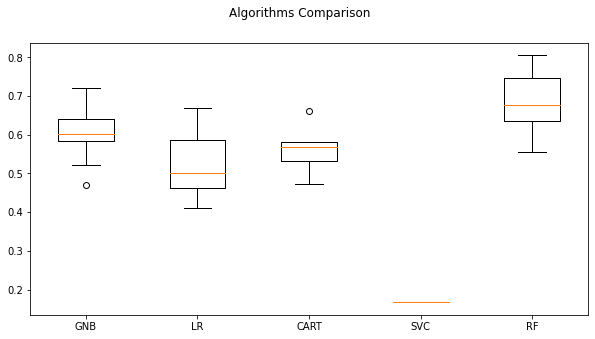

In [50]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [51]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if choosenIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.50      0.83      0.62        30
           1       0.79      0.50      0.61        30
           2       0.62      0.43      0.51        30

    accuracy                           0.59        90
   macro avg       0.64      0.59      0.58        90
weighted avg       0.64      0.59      0.58        90

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        30
           1       0.74      0.57      0.64        30
           2       0.53      0.63      0.58        30

    accuracy                           0.59        90
   macro avg       0.61      0.59      0.59        90
weighted avg       0.61      0.59      0.59        90

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.56

## Valutazione Inferance Rate medio (|X_test| = 40)

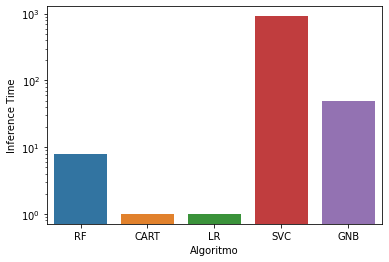

In [52]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

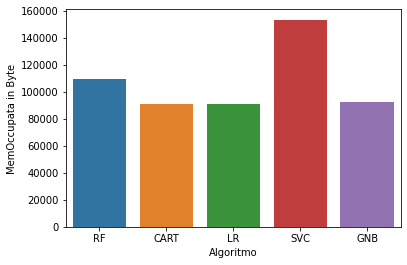

In [53]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [75]:
EPOCHS = 1000 #if labels == 3 else 500
BATCH_SIZE = 4
learn_rate = 0.0001
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [160]:
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 1285      
Total params: 10,789
Trainable params: 10,789
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
135/135 [==============================] - 0s 467us/step - loss: 1.6556 - accuracy: 0.1796
Epoch 2/100

KeyboardInterrupt: 

## Train and Test

In [76]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 771       
Total params: 10,275
Trainable params: 10,275
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
68/68 [==============================] - 0s 4ms/step - loss: 308.0091 - accuracy: 0.3296 - val_loss: 9

Epoch 50/1000
68/68 [==============================] - 0s 719us/step - loss: 28.0298 - accuracy: 0.5037 - val_loss: 17.8622 - val_accuracy: 0.6778
Epoch 51/1000
68/68 [==============================] - 0s 742us/step - loss: 29.2722 - accuracy: 0.5296 - val_loss: 16.5419 - val_accuracy: 0.6778
Epoch 52/1000
68/68 [==============================] - 0s 717us/step - loss: 25.5834 - accuracy: 0.5444 - val_loss: 14.7746 - val_accuracy: 0.6778
Epoch 53/1000
68/68 [==============================] - 0s 1ms/step - loss: 26.6618 - accuracy: 0.5222 - val_loss: 14.5382 - val_accuracy: 0.6778
Epoch 54/1000
68/68 [==============================] - 0s 740us/step - loss: 20.4913 - accuracy: 0.5593 - val_loss: 15.7615 - val_accuracy: 0.6667
Epoch 55/1000
68/68 [==============================] - 0s 728us/step - loss: 26.4294 - accuracy: 0.5074 - val_loss: 17.1543 - val_accuracy: 0.6444
Epoch 56/1000
68/68 [==============================] - 0s 762us/step - loss: 19.4758 - accuracy: 0.5519 - val_loss: 15.8

68/68 [==============================] - 0s 719us/step - loss: 4.7580 - accuracy: 0.6037 - val_loss: 6.6152 - val_accuracy: 0.6889
Epoch 107/1000
68/68 [==============================] - 0s 723us/step - loss: 3.7953 - accuracy: 0.6074 - val_loss: 6.8394 - val_accuracy: 0.7000
Epoch 108/1000
68/68 [==============================] - 0s 702us/step - loss: 2.4808 - accuracy: 0.6148 - val_loss: 6.5397 - val_accuracy: 0.6889
Epoch 109/1000
68/68 [==============================] - 0s 727us/step - loss: 3.0610 - accuracy: 0.6185 - val_loss: 6.5863 - val_accuracy: 0.6889
Epoch 110/1000
68/68 [==============================] - 0s 710us/step - loss: 4.4719 - accuracy: 0.6296 - val_loss: 6.4971 - val_accuracy: 0.6778
Epoch 111/1000
68/68 [==============================] - 0s 720us/step - loss: 3.7400 - accuracy: 0.6074 - val_loss: 6.7095 - val_accuracy: 0.6778
Epoch 112/1000
68/68 [==============================] - 0s 1ms/step - loss: 2.9608 - accuracy: 0.6148 - val_loss: 6.7807 - val_accuracy: 0.

68/68 [==============================] - 0s 758us/step - loss: 1.6753 - accuracy: 0.6000 - val_loss: 4.4597 - val_accuracy: 0.6667
Epoch 163/1000
68/68 [==============================] - 0s 723us/step - loss: 1.7314 - accuracy: 0.5778 - val_loss: 4.2347 - val_accuracy: 0.6444
Epoch 164/1000
68/68 [==============================] - 0s 713us/step - loss: 1.1584 - accuracy: 0.6370 - val_loss: 4.1900 - val_accuracy: 0.6667
Epoch 165/1000
68/68 [==============================] - 0s 715us/step - loss: 1.5569 - accuracy: 0.6000 - val_loss: 3.8967 - val_accuracy: 0.6667
Epoch 166/1000
68/68 [==============================] - 0s 714us/step - loss: 1.1010 - accuracy: 0.6148 - val_loss: 3.8977 - val_accuracy: 0.6778
Epoch 167/1000
68/68 [==============================] - 0s 740us/step - loss: 1.1482 - accuracy: 0.6259 - val_loss: 3.6865 - val_accuracy: 0.6667
Epoch 168/1000
68/68 [==============================] - 0s 746us/step - loss: 1.1410 - accuracy: 0.6333 - val_loss: 3.8139 - val_accuracy: 

68/68 [==============================] - 0s 741us/step - loss: 0.9473 - accuracy: 0.6148 - val_loss: 2.3782 - val_accuracy: 0.6556
Epoch 219/1000
68/68 [==============================] - 0s 752us/step - loss: 0.8344 - accuracy: 0.5926 - val_loss: 2.5640 - val_accuracy: 0.6667
Epoch 220/1000
68/68 [==============================] - 0s 746us/step - loss: 0.9941 - accuracy: 0.5815 - val_loss: 2.2017 - val_accuracy: 0.6778
Epoch 221/1000
68/68 [==============================] - 0s 739us/step - loss: 0.8315 - accuracy: 0.5889 - val_loss: 2.2059 - val_accuracy: 0.6667
Epoch 222/1000
68/68 [==============================] - 0s 736us/step - loss: 0.7390 - accuracy: 0.6185 - val_loss: 2.2530 - val_accuracy: 0.6667
Epoch 223/1000
68/68 [==============================] - 0s 730us/step - loss: 0.8708 - accuracy: 0.5963 - val_loss: 2.2713 - val_accuracy: 0.6667
Epoch 224/1000
68/68 [==============================] - 0s 742us/step - loss: 0.9353 - accuracy: 0.5741 - val_loss: 2.3993 - val_accuracy: 

68/68 [==============================] - 0s 741us/step - loss: 0.7365 - accuracy: 0.6185 - val_loss: 2.6457 - val_accuracy: 0.6444
Epoch 275/1000
68/68 [==============================] - 0s 742us/step - loss: 0.9933 - accuracy: 0.5778 - val_loss: 2.7896 - val_accuracy: 0.6556
Epoch 276/1000
68/68 [==============================] - 0s 741us/step - loss: 0.8129 - accuracy: 0.6000 - val_loss: 2.7928 - val_accuracy: 0.6444
Epoch 277/1000
68/68 [==============================] - 0s 762us/step - loss: 0.8035 - accuracy: 0.6037 - val_loss: 2.8240 - val_accuracy: 0.6444
Epoch 278/1000
68/68 [==============================] - 0s 722us/step - loss: 0.7808 - accuracy: 0.5926 - val_loss: 2.9246 - val_accuracy: 0.6667
Epoch 279/1000
68/68 [==============================] - 0s 744us/step - loss: 0.8854 - accuracy: 0.5963 - val_loss: 2.8563 - val_accuracy: 0.6667
Epoch 280/1000
68/68 [==============================] - 0s 700us/step - loss: 0.7716 - accuracy: 0.6148 - val_loss: 2.8398 - val_accuracy: 

68/68 [==============================] - 0s 826us/step - loss: 0.8366 - accuracy: 0.6074 - val_loss: 2.4998 - val_accuracy: 0.6556
Epoch 331/1000
68/68 [==============================] - 0s 736us/step - loss: 0.8217 - accuracy: 0.6074 - val_loss: 2.5363 - val_accuracy: 0.6444
Epoch 332/1000
68/68 [==============================] - 0s 731us/step - loss: 0.7817 - accuracy: 0.6000 - val_loss: 2.3796 - val_accuracy: 0.6556
Epoch 333/1000
68/68 [==============================] - 0s 736us/step - loss: 0.7475 - accuracy: 0.6111 - val_loss: 2.4308 - val_accuracy: 0.6667
Epoch 334/1000
68/68 [==============================] - 0s 726us/step - loss: 0.7826 - accuracy: 0.5889 - val_loss: 2.4222 - val_accuracy: 0.6667
Epoch 335/1000
68/68 [==============================] - 0s 724us/step - loss: 0.8455 - accuracy: 0.6037 - val_loss: 2.4540 - val_accuracy: 0.6667
Epoch 336/1000
68/68 [==============================] - 0s 740us/step - loss: 0.8105 - accuracy: 0.5889 - val_loss: 2.4768 - val_accuracy: 

68/68 [==============================] - 0s 763us/step - loss: 0.7434 - accuracy: 0.6037 - val_loss: 2.7286 - val_accuracy: 0.6333
Epoch 387/1000
68/68 [==============================] - 0s 716us/step - loss: 0.7635 - accuracy: 0.6074 - val_loss: 2.7742 - val_accuracy: 0.6333
Epoch 388/1000
68/68 [==============================] - 0s 777us/step - loss: 0.7122 - accuracy: 0.6222 - val_loss: 2.7847 - val_accuracy: 0.6333
Epoch 389/1000
68/68 [==============================] - 0s 841us/step - loss: 0.7618 - accuracy: 0.6148 - val_loss: 2.7709 - val_accuracy: 0.6333
Epoch 390/1000
68/68 [==============================] - 0s 728us/step - loss: 0.7365 - accuracy: 0.6222 - val_loss: 2.7510 - val_accuracy: 0.6333
Epoch 391/1000
68/68 [==============================] - 0s 742us/step - loss: 0.8026 - accuracy: 0.6000 - val_loss: 2.7745 - val_accuracy: 0.6444
Epoch 392/1000
68/68 [==============================] - 0s 732us/step - loss: 0.9085 - accuracy: 0.5778 - val_loss: 2.9522 - val_accuracy: 

68/68 [==============================] - 0s 750us/step - loss: 0.7345 - accuracy: 0.6185 - val_loss: 2.9615 - val_accuracy: 0.6444
Epoch 443/1000
68/68 [==============================] - 0s 727us/step - loss: 0.7994 - accuracy: 0.6074 - val_loss: 2.9604 - val_accuracy: 0.6444
Epoch 444/1000
68/68 [==============================] - 0s 722us/step - loss: 0.7897 - accuracy: 0.5815 - val_loss: 2.7742 - val_accuracy: 0.6444
Epoch 445/1000
68/68 [==============================] - 0s 723us/step - loss: 0.7772 - accuracy: 0.5926 - val_loss: 2.8114 - val_accuracy: 0.6444
Epoch 446/1000
68/68 [==============================] - 0s 730us/step - loss: 0.8079 - accuracy: 0.6148 - val_loss: 2.8220 - val_accuracy: 0.6222
Epoch 447/1000
68/68 [==============================] - 0s 737us/step - loss: 0.7576 - accuracy: 0.5926 - val_loss: 2.8656 - val_accuracy: 0.6444
Epoch 448/1000
68/68 [==============================] - 0s 805us/step - loss: 0.8051 - accuracy: 0.5926 - val_loss: 2.8827 - val_accuracy: 

68/68 [==============================] - 0s 749us/step - loss: 0.7648 - accuracy: 0.5852 - val_loss: 3.0475 - val_accuracy: 0.6333
Epoch 499/1000
68/68 [==============================] - 0s 723us/step - loss: 0.7189 - accuracy: 0.6185 - val_loss: 3.0199 - val_accuracy: 0.6333
Epoch 500/1000
68/68 [==============================] - 0s 727us/step - loss: 0.7345 - accuracy: 0.6111 - val_loss: 3.0227 - val_accuracy: 0.6333
Epoch 501/1000
68/68 [==============================] - 0s 720us/step - loss: 0.7251 - accuracy: 0.6148 - val_loss: 3.0311 - val_accuracy: 0.6444
Epoch 502/1000
68/68 [==============================] - 0s 750us/step - loss: 0.7780 - accuracy: 0.6222 - val_loss: 3.1053 - val_accuracy: 0.6444
Epoch 503/1000
68/68 [==============================] - 0s 725us/step - loss: 0.7200 - accuracy: 0.6259 - val_loss: 3.0859 - val_accuracy: 0.6444
Epoch 504/1000
68/68 [==============================] - 0s 720us/step - loss: 0.7308 - accuracy: 0.6148 - val_loss: 3.0885 - val_accuracy: 

68/68 [==============================] - 0s 714us/step - loss: 0.7175 - accuracy: 0.6185 - val_loss: 2.9871 - val_accuracy: 0.6556
Epoch 555/1000
68/68 [==============================] - 0s 724us/step - loss: 0.7233 - accuracy: 0.6185 - val_loss: 3.0131 - val_accuracy: 0.6556
Epoch 556/1000
68/68 [==============================] - 0s 738us/step - loss: 0.7335 - accuracy: 0.6074 - val_loss: 3.0125 - val_accuracy: 0.6556
Epoch 557/1000
68/68 [==============================] - 0s 717us/step - loss: 0.7784 - accuracy: 0.6185 - val_loss: 3.0655 - val_accuracy: 0.6556
Epoch 558/1000
68/68 [==============================] - 0s 721us/step - loss: 0.7095 - accuracy: 0.6185 - val_loss: 3.1457 - val_accuracy: 0.6444
Epoch 559/1000
68/68 [==============================] - 0s 731us/step - loss: 0.7287 - accuracy: 0.6074 - val_loss: 3.0529 - val_accuracy: 0.6556
Epoch 560/1000
68/68 [==============================] - 0s 732us/step - loss: 0.7559 - accuracy: 0.6148 - val_loss: 3.0644 - val_accuracy: 

68/68 [==============================] - 0s 710us/step - loss: 0.7211 - accuracy: 0.6148 - val_loss: 2.3372 - val_accuracy: 0.6556
Epoch 611/1000
68/68 [==============================] - 0s 711us/step - loss: 0.7629 - accuracy: 0.6296 - val_loss: 2.3415 - val_accuracy: 0.6556
Epoch 612/1000
68/68 [==============================] - 0s 745us/step - loss: 0.7219 - accuracy: 0.6148 - val_loss: 2.3700 - val_accuracy: 0.6556
Epoch 613/1000
68/68 [==============================] - 0s 716us/step - loss: 0.7547 - accuracy: 0.6296 - val_loss: 2.5286 - val_accuracy: 0.6556
Epoch 614/1000
68/68 [==============================] - 0s 759us/step - loss: 0.7295 - accuracy: 0.6185 - val_loss: 2.5594 - val_accuracy: 0.6556
Epoch 615/1000
68/68 [==============================] - 0s 728us/step - loss: 0.8255 - accuracy: 0.5889 - val_loss: 2.5301 - val_accuracy: 0.6556
Epoch 616/1000
68/68 [==============================] - 0s 714us/step - loss: 0.7733 - accuracy: 0.6370 - val_loss: 2.5841 - val_accuracy: 

68/68 [==============================] - 0s 727us/step - loss: 0.7426 - accuracy: 0.6259 - val_loss: 2.6142 - val_accuracy: 0.6778
Epoch 667/1000
68/68 [==============================] - 0s 825us/step - loss: 0.6817 - accuracy: 0.6556 - val_loss: 2.6106 - val_accuracy: 0.6778
Epoch 668/1000
68/68 [==============================] - 0s 751us/step - loss: 0.7061 - accuracy: 0.6333 - val_loss: 2.6242 - val_accuracy: 0.6778
Epoch 669/1000
68/68 [==============================] - 0s 717us/step - loss: 0.7069 - accuracy: 0.6296 - val_loss: 2.5945 - val_accuracy: 0.6778
Epoch 670/1000
68/68 [==============================] - 0s 713us/step - loss: 0.7040 - accuracy: 0.6333 - val_loss: 2.6173 - val_accuracy: 0.6778
Epoch 671/1000
68/68 [==============================] - 0s 734us/step - loss: 0.7717 - accuracy: 0.6407 - val_loss: 2.5372 - val_accuracy: 0.6778
Epoch 672/1000
68/68 [==============================] - 0s 738us/step - loss: 0.7234 - accuracy: 0.6407 - val_loss: 2.5215 - val_accuracy: 

68/68 [==============================] - 0s 721us/step - loss: 0.6928 - accuracy: 0.6407 - val_loss: 2.6108 - val_accuracy: 0.6778
Epoch 723/1000
68/68 [==============================] - 0s 734us/step - loss: 0.7035 - accuracy: 0.6296 - val_loss: 2.6096 - val_accuracy: 0.6778
Epoch 724/1000
68/68 [==============================] - 0s 705us/step - loss: 0.6925 - accuracy: 0.6481 - val_loss: 2.6367 - val_accuracy: 0.6778
Epoch 725/1000
68/68 [==============================] - 0s 719us/step - loss: 0.6934 - accuracy: 0.6407 - val_loss: 2.6554 - val_accuracy: 0.6778
Epoch 726/1000
68/68 [==============================] - 0s 709us/step - loss: 0.6678 - accuracy: 0.6556 - val_loss: 2.5879 - val_accuracy: 0.6889
Epoch 727/1000
68/68 [==============================] - 0s 830us/step - loss: 0.6727 - accuracy: 0.6481 - val_loss: 2.5799 - val_accuracy: 0.6889
Epoch 728/1000
68/68 [==============================] - 0s 723us/step - loss: 0.7381 - accuracy: 0.6556 - val_loss: 2.7075 - val_accuracy: 

68/68 [==============================] - 0s 732us/step - loss: 0.6651 - accuracy: 0.6630 - val_loss: 3.0399 - val_accuracy: 0.7000
Epoch 779/1000
68/68 [==============================] - 0s 745us/step - loss: 0.7025 - accuracy: 0.6407 - val_loss: 3.0415 - val_accuracy: 0.7000
Epoch 780/1000
68/68 [==============================] - 0s 729us/step - loss: 0.6637 - accuracy: 0.6630 - val_loss: 3.0443 - val_accuracy: 0.7000
Epoch 781/1000
68/68 [==============================] - 0s 731us/step - loss: 0.7001 - accuracy: 0.6407 - val_loss: 3.0525 - val_accuracy: 0.6889
Epoch 782/1000
68/68 [==============================] - 0s 715us/step - loss: 0.6413 - accuracy: 0.6704 - val_loss: 3.0454 - val_accuracy: 0.6889
Epoch 783/1000
68/68 [==============================] - 0s 720us/step - loss: 0.7011 - accuracy: 0.6333 - val_loss: 2.9517 - val_accuracy: 0.6889
Epoch 784/1000
68/68 [==============================] - 0s 702us/step - loss: 0.7207 - accuracy: 0.6296 - val_loss: 2.7298 - val_accuracy: 

68/68 [==============================] - 0s 722us/step - loss: 0.6733 - accuracy: 0.6556 - val_loss: 2.9799 - val_accuracy: 0.6778
Epoch 835/1000
68/68 [==============================] - 0s 744us/step - loss: 0.7010 - accuracy: 0.6519 - val_loss: 2.9150 - val_accuracy: 0.6667
Epoch 836/1000
68/68 [==============================] - 0s 717us/step - loss: 0.6961 - accuracy: 0.6296 - val_loss: 2.8446 - val_accuracy: 0.6889
Epoch 837/1000
68/68 [==============================] - 0s 751us/step - loss: 0.6935 - accuracy: 0.6370 - val_loss: 2.8298 - val_accuracy: 0.7111
Epoch 838/1000
68/68 [==============================] - 0s 759us/step - loss: 0.6887 - accuracy: 0.6407 - val_loss: 2.8686 - val_accuracy: 0.7000
Epoch 839/1000
68/68 [==============================] - 0s 740us/step - loss: 0.6831 - accuracy: 0.6519 - val_loss: 2.8927 - val_accuracy: 0.7000
Epoch 840/1000
68/68 [==============================] - 0s 736us/step - loss: 0.6862 - accuracy: 0.6519 - val_loss: 2.8894 - val_accuracy: 

68/68 [==============================] - 0s 722us/step - loss: 0.6939 - accuracy: 0.6407 - val_loss: 2.8285 - val_accuracy: 0.7000
Epoch 891/1000
68/68 [==============================] - 0s 733us/step - loss: 0.6461 - accuracy: 0.6704 - val_loss: 3.5557 - val_accuracy: 0.7000
Epoch 892/1000
68/68 [==============================] - 0s 743us/step - loss: 0.7074 - accuracy: 0.6481 - val_loss: 3.0699 - val_accuracy: 0.6889
Epoch 893/1000
68/68 [==============================] - 0s 719us/step - loss: 0.6785 - accuracy: 0.6519 - val_loss: 2.9189 - val_accuracy: 0.7000
Epoch 894/1000
68/68 [==============================] - 0s 715us/step - loss: 0.6894 - accuracy: 0.6519 - val_loss: 3.2576 - val_accuracy: 0.6778
Epoch 895/1000
68/68 [==============================] - 0s 710us/step - loss: 0.7189 - accuracy: 0.6444 - val_loss: 3.6849 - val_accuracy: 0.6889
Epoch 896/1000
68/68 [==============================] - 0s 708us/step - loss: 0.6840 - accuracy: 0.6519 - val_loss: 3.3762 - val_accuracy: 

68/68 [==============================] - 0s 1ms/step - loss: 0.6742 - accuracy: 0.6519 - val_loss: 2.8345 - val_accuracy: 0.7111
Epoch 947/1000
68/68 [==============================] - 0s 753us/step - loss: 0.6519 - accuracy: 0.6667 - val_loss: 2.8497 - val_accuracy: 0.7111
Epoch 948/1000
68/68 [==============================] - 0s 758us/step - loss: 0.6769 - accuracy: 0.6519 - val_loss: 2.8727 - val_accuracy: 0.7111
Epoch 949/1000
68/68 [==============================] - 0s 725us/step - loss: 0.6916 - accuracy: 0.6481 - val_loss: 2.9592 - val_accuracy: 0.7111
Epoch 950/1000
68/68 [==============================] - 0s 762us/step - loss: 0.6467 - accuracy: 0.6704 - val_loss: 2.9750 - val_accuracy: 0.7111
Epoch 951/1000
68/68 [==============================] - 0s 721us/step - loss: 0.6799 - accuracy: 0.6444 - val_loss: 2.9643 - val_accuracy: 0.7111
Epoch 952/1000
68/68 [==============================] - 0s 703us/step - loss: 0.6846 - accuracy: 0.6481 - val_loss: 2.9698 - val_accuracy: 0.

In [77]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        30
           1       0.87      0.43      0.58        30
           2       0.45      0.77      0.57        30

    accuracy                           0.58        90
   macro avg       0.66      0.58      0.58        90
weighted avg       0.66      0.58      0.58        90



# Export Models in C code

In [78]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpx5bgf0yx/assets


INFO:tensorflow:Assets written to: /tmp/tmpx5bgf0yx/assets
